# Project Food101

In [1]:
## Check if gpu is enabled for better performance
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b8e6226d-7231-574c-158b-c0a6e40e43b9)


## Get our data ready

In [2]:
# This data contrains only 10 % of the train data but contains all 25250 images for test data
# i.e. 250 images for each of the class
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
zip = zipfile.ZipFile("101_food_classes_10_percent.zip")
zip.extractall()

--2021-07-31 18:12:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   116MB/s    in 7.6s    

2021-07-31 18:12:14 (203 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [3]:
test_dir =  "101_food_classes_10_percent/test"
IMG_SIZE =(224,224)

In [9]:
import tensorflow as tf
import numpy as np

In [5]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 25250 files belonging to 101 classes.


## Load the trained model and evaluate 

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/models_tf/project_food101_fine_tuned_model")

In [40]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.8135049504950495

In [7]:
# Make predictions on test
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 172s 180ms/step


Evaluate them by comparing to original labels

## Unbatch datasets

In [10]:
pred_classes = np.argmax(preds_probs,axis=1)

In [11]:
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
len(y_labels)

25250

 ## Confusion Matrix Plot

In [14]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix_l(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ###Changed plot x labels vertically###

  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  

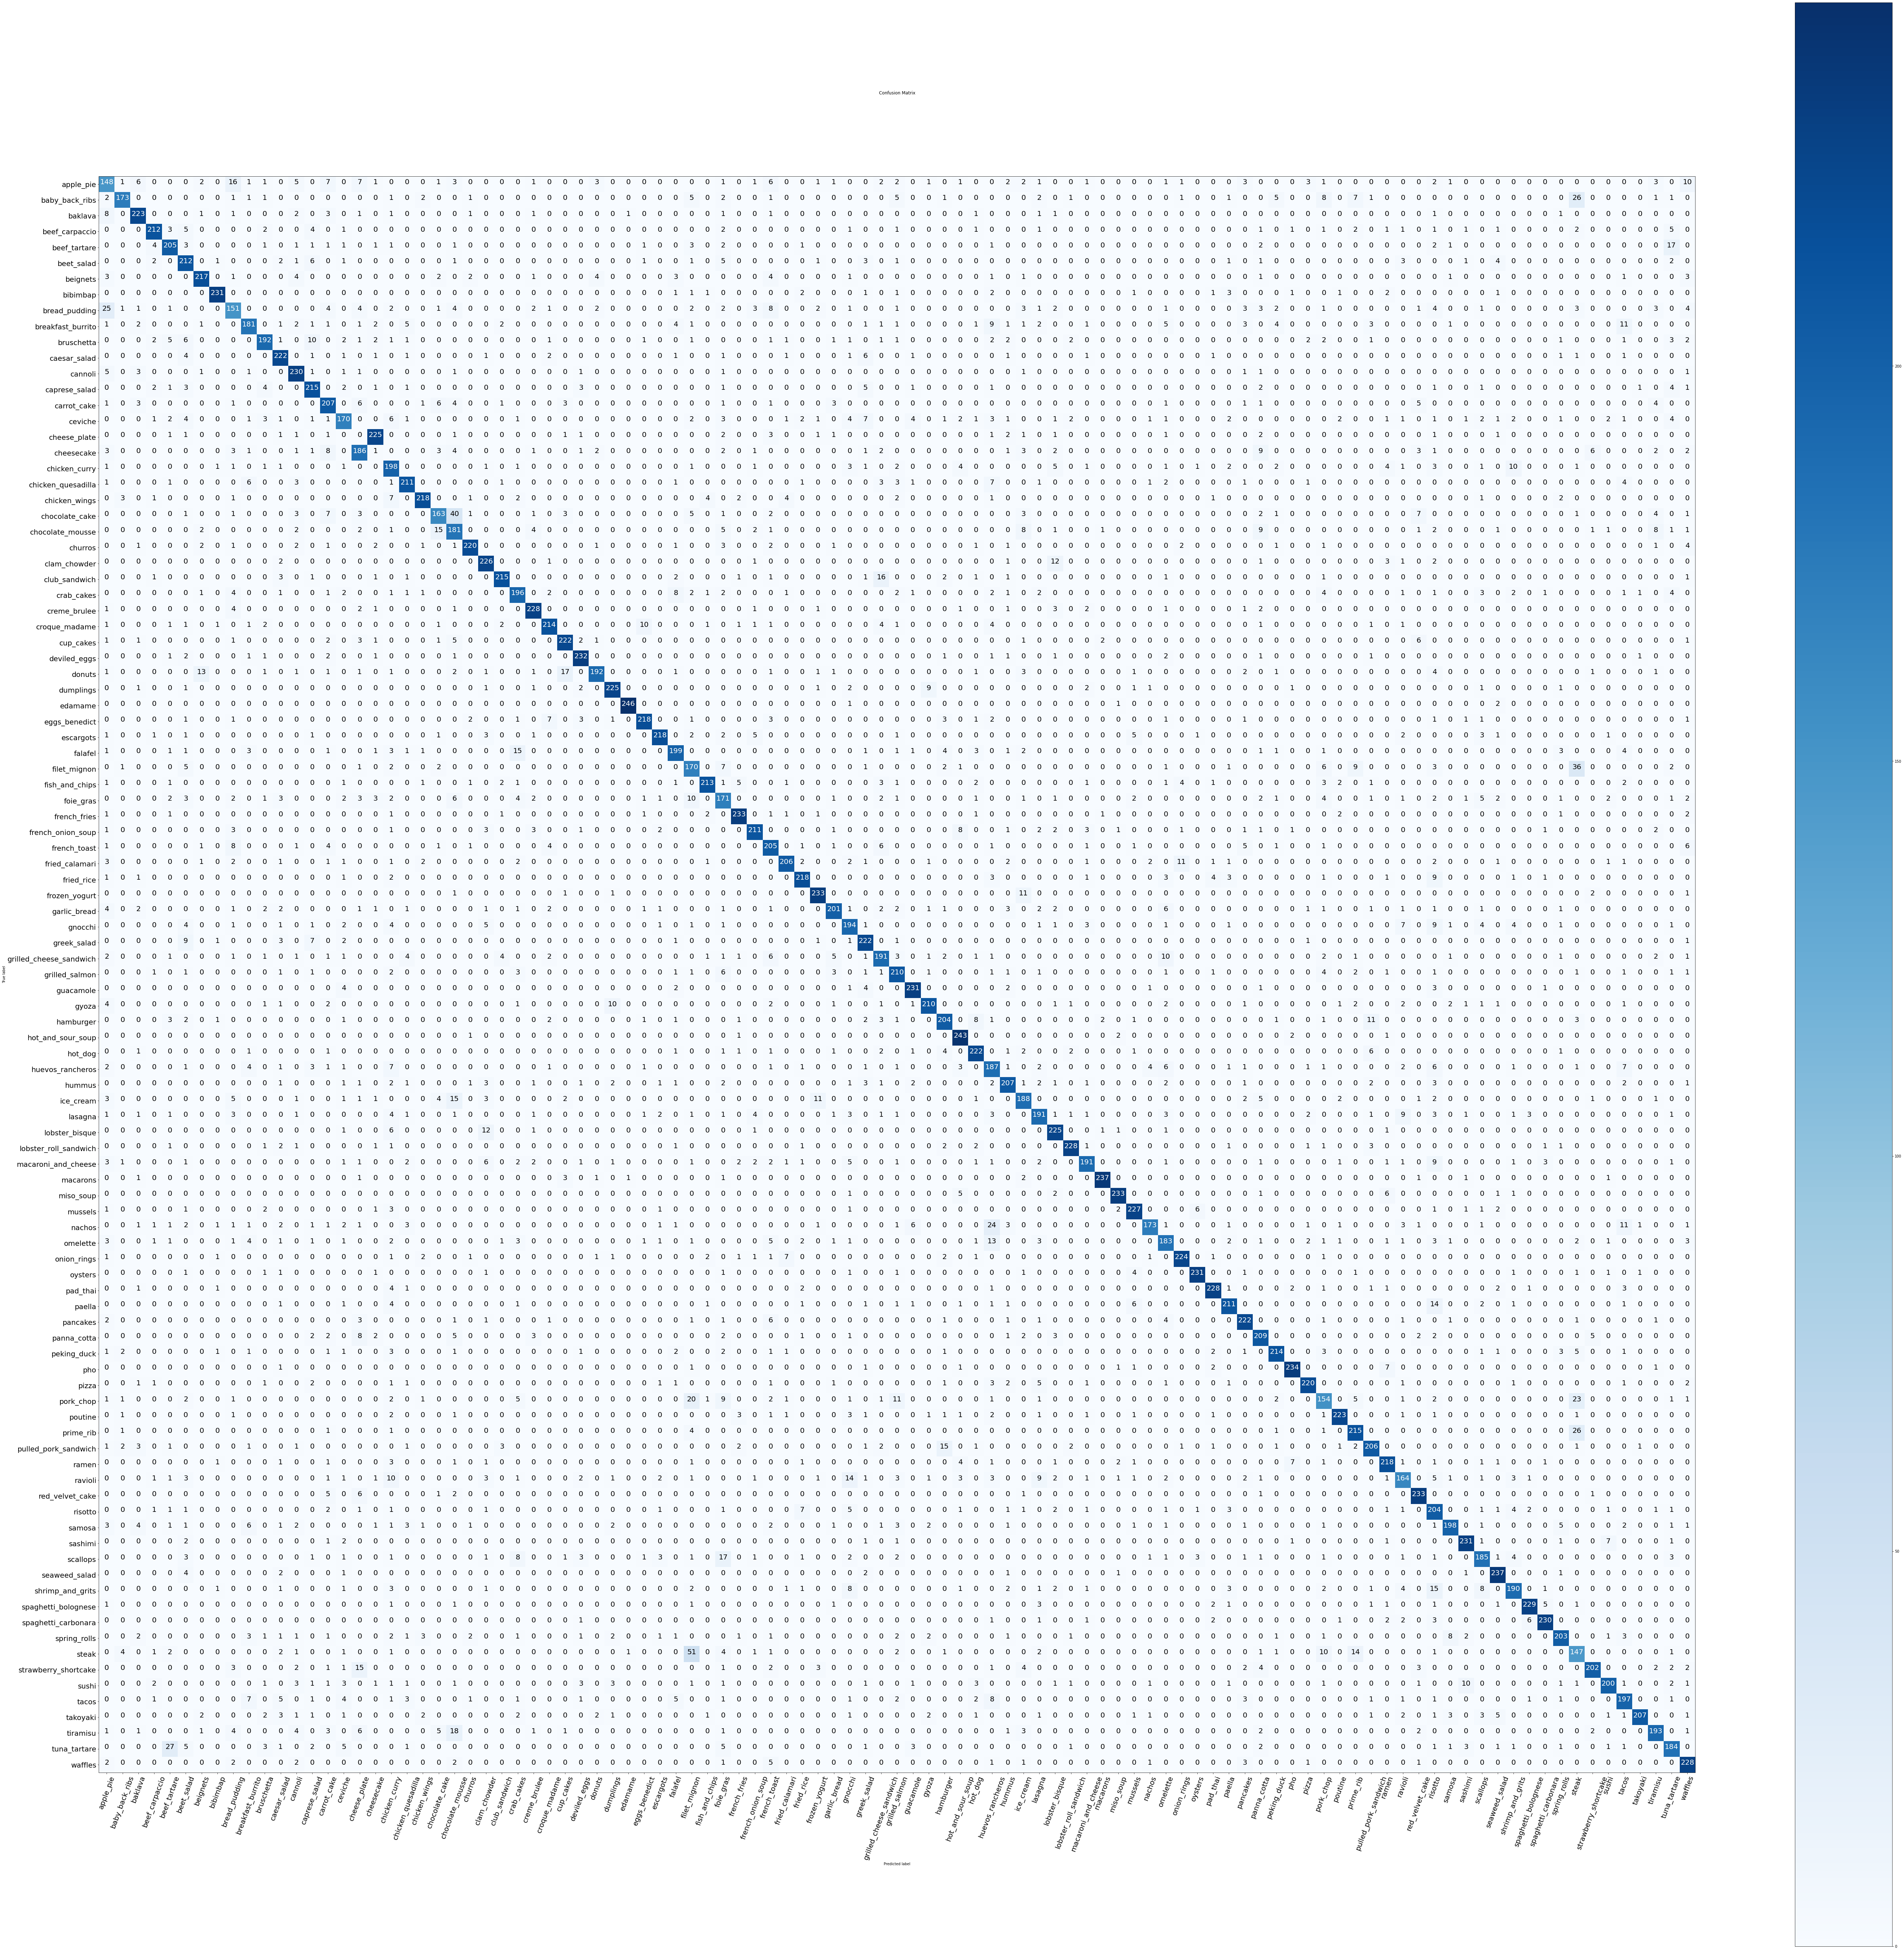

In [16]:
class_names= test_data.class_names
make_confusion_matrix_l(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

##  Visualize F1-scores for all the food class


In [17]:
from sklearn.metrics import classification_report


In [18]:
c_report = classification_report(y_true=y_labels,
                            y_pred=pred_classes,output_dict=True)

In [19]:
class_f1_scores = {}
class_precision = {}
class_recall = {}
for k,v in c_report.items():
  if k == "accuracy":
    break
  class_f1_scores[class_names[int(k)]] = np.round(v["f1-score"],4)
  class_precision[class_names[int(k)]] = v["precision"]
  class_recall[class_names[int(k)]] =    v["recall"]

In [20]:
import pandas as pd

f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [21]:
f1_scores

,class_names,f1-score
33,edamame,0.9860
63,macarons,0.9595
64,miso_soup,0.9414
7,bibimbap,0.9390
69,oysters,0.9371
...,...,...
37,filet_mignon,0.6227
0,apple_pie,0.5944
93,steak,0.5506
17,cheesecake,0.0040


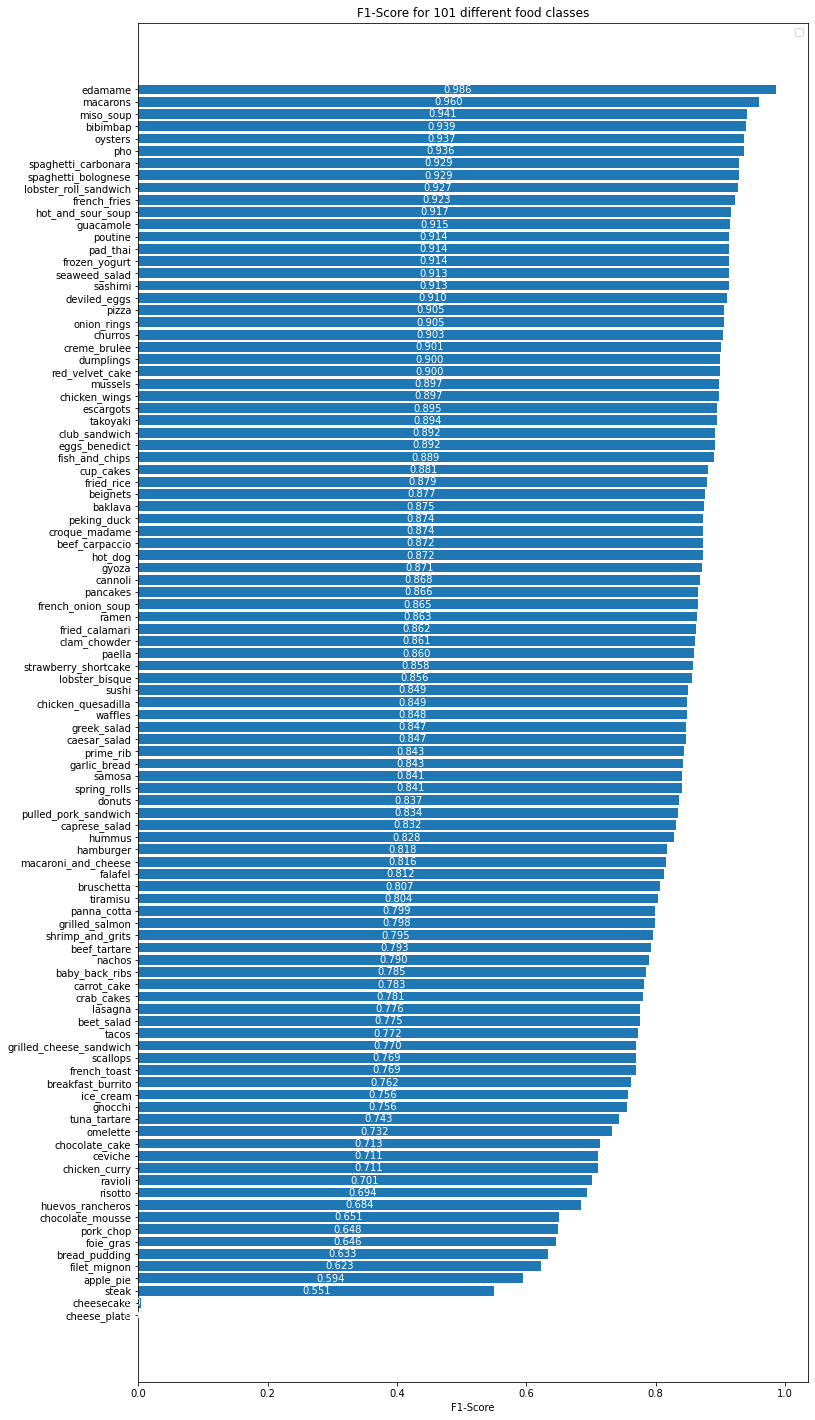

In [22]:
import matplotlib.pyplot as plt

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height()/2.,
                '%.3f' % width,
                ha='center', va='center', color='white')

fig,ax, = plt.subplots(figsize=(12,25))
score = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Score for 101 different food classes")
ax.legend()
autolabel(ax.patches)


ax.invert_yaxis()

In [23]:
def load_and_prep(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turn into tensor and reshapes into 
  specified shape (img_shape,img_shape,color_channels=3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width of target image size
    scale (bool): if true then scale pixel values from 0-255 to 0-1

  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read the image
  img = tf.io.read_file(filename)

  # Decode the image into tensor
  img = tf.io.decode_image(img,channels=3)
  
  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/NO
  if scale:
    return img/255.
  return img

## Visualizing our predictions

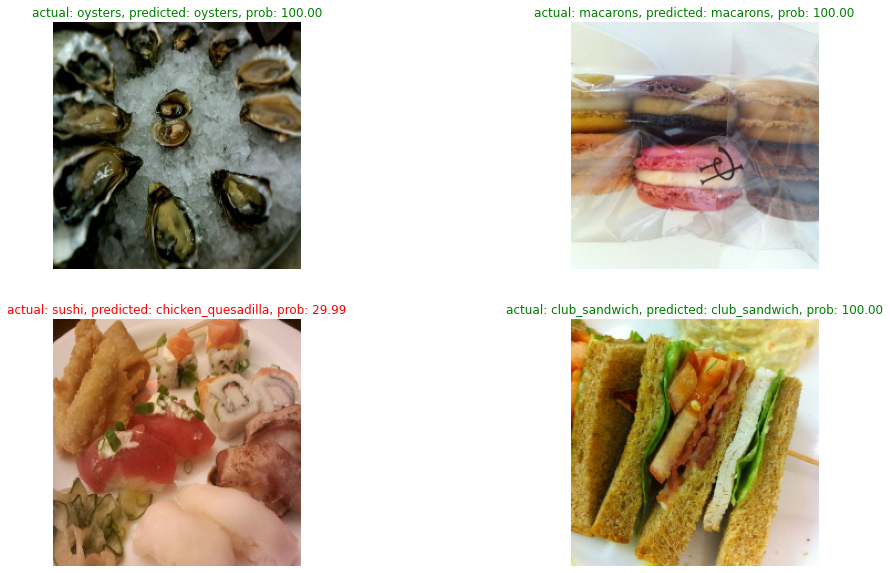

In [24]:
# Select four images randomly and predict their class
import os 
import random

plt.figure(figsize=(17,10))

for i in range(4):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + "/" + class_name + "/" + filename
  img = load_and_prep(filepath,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.subplot(2,2,i+1)
  plt.imshow(img/255.)
  plt.axis(False)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, predicted: {pred_class}, prob: {pred_prob.max()*100:.2f}",c=title_color)

## Finding Most Wrong Predictions
1. Get all image paths using list_files method
2. Create pandas dataframe of filepath, true label, predicted label, max predicition probabilities
3. Use our dataframe to find all wrong predictions
4. Sort the dataframe based on wrong predictions
5. Visualize the images with highest prediction probabilities that have the wrong predictions

In [25]:
# get all image file paths 
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
  

In [26]:
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

In [27]:
#3. Find which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.990206,apple_pie,samosa,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.998422,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.989095,apple_pie,gyoza,False
3,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.999998,apple_pie,apple_pie,True
4,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.997947,apple_pie,apple_pie,True


In [28]:
#4 sort the dataframe  to have most wrong predictions at top

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)
len(top_100_wrong)

100

### Visualize the most wrong predictions

In [36]:
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turn into tensor and reshapes into 
  specified shape (img_shape,img_shape,color_channels=3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width of target image size
    scale (bool): if true then scale pixel values from 0-255 to 0-1

  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read the image
  img = tf.io.read_file(filename)

  # Decode the image into tensor
  img = tf.io.decode_image(img,channels=3)
  
  # Resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/NO
  if scale:
    return img/255.
  return img

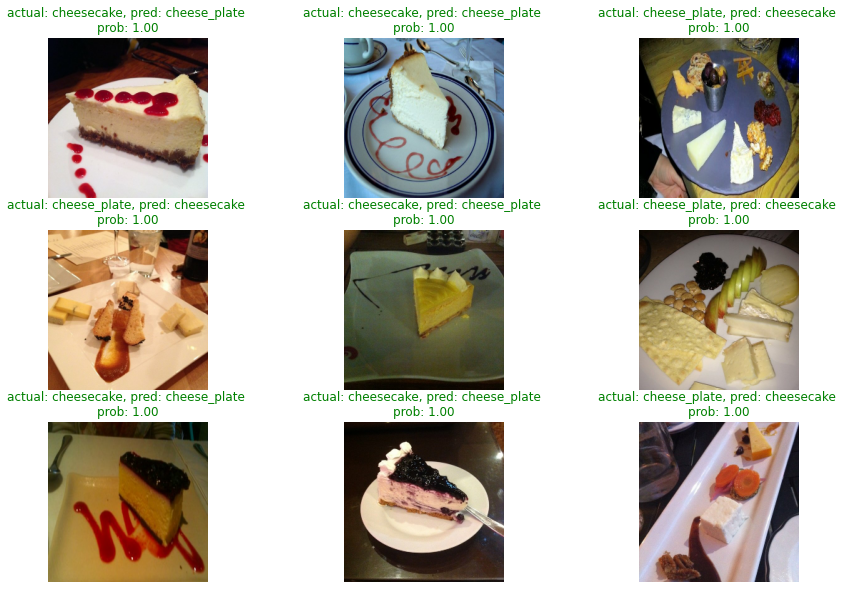

In [37]:
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}",c=title_color)
  plt.axis(False)

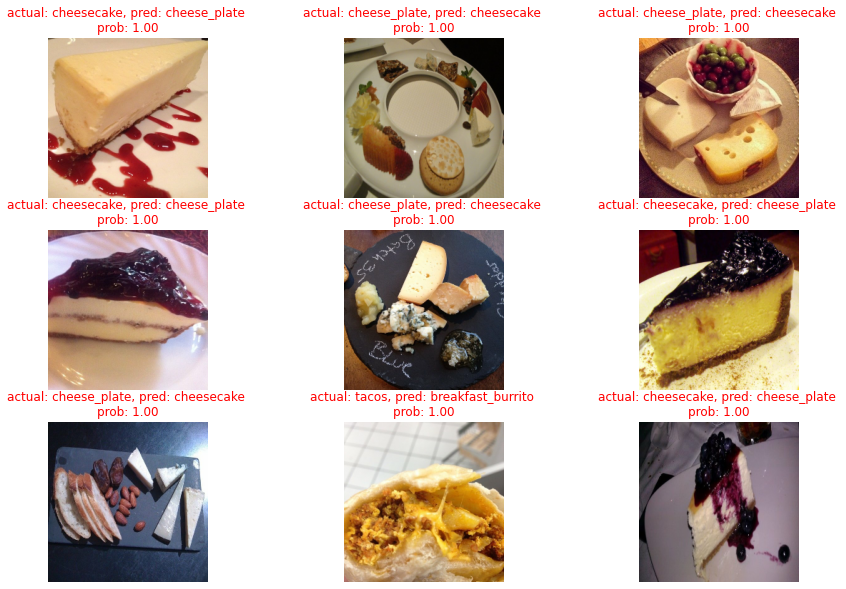

In [38]:
start_index = 20 # change the start index to view more
images_to_view = 9

plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)

  if y_true == y_pred:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}",c=title_color)
  plt.axis(False)